In [9]:
# Load modules
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Global configuration
PATH = 'train'
class_names = os.listdir(PATH)
data_dir = pathlib.Path( PATH )
batch_size = 32
image_size = 50
num_classes = len(class_names)
validation_split = 0.1

print(class_names)

['Crosswalk', 'No Parking', 'Stop', 'Turn Left', 'Turn Right']


In [10]:
# Create the dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split = validation_split,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size
)

# Create the dataset for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split = validation_split,
    subset = "validation",
    seed = 123,
    image_size = (image_size, image_size),
    batch_size = batch_size
)

# cache
train_ds  = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds    = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Found 849 files belonging to 5 classes.
Using 765 files for training.
Found 849 files belonging to 5 classes.
Using 84 files for validation.


### Custom built CNN

In [11]:
# Data Augmentation
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(image_size, image_size),
  tf.keras.layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

# Sequential model
model = tf.keras.Sequential([
    
#   resize_and_rescale,
#   data_augmentation,
    
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
            optimizer = tf.keras.optimizers.Adam(0.01),
            loss = [tf.keras.losses.SparseCategoricalCrossentropy(),],
            metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50
)

Epoch 1/50
24/24 [==============================] - 4s 89ms/step - loss: 2.6488 - accuracy: 0.2758 - val_loss: 1.9193 - val_accuracy: 0.2381
Epoch 2/50
24/24 [==============================] - 1s 54ms/step - loss: 1.3210 - accuracy: 0.4235 - val_loss: 1.8960 - val_accuracy: 0.2976
Epoch 3/50
24/24 [==============================] - 1s 58ms/step - loss: 1.2036 - accuracy: 0.4797 - val_loss: 2.0730 - val_accuracy: 0.3333
Epoch 4/50
24/24 [==============================] - 1s 57ms/step - loss: 1.0797 - accuracy: 0.5281 - val_loss: 0.9850 - val_accuracy: 0.6429
Epoch 5/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9957 - accuracy: 0.6000 - val_loss: 1.0420 - val_accuracy: 0.6429
Epoch 6/50
24/24 [==============================] - 2s 64ms/step - loss: 0.9271 - accuracy: 0.6353 - val_loss: 0.9200 - val_accuracy: 0.6667
Epoch 7/50
24/24 [==============================] - 2s 63ms/step - loss: 0.8622 - accuracy: 0.6601 - val_loss: 0.6751 - val_accuracy: 0.7738
Epoch 8/50
24

### Save and Evaluate the Model

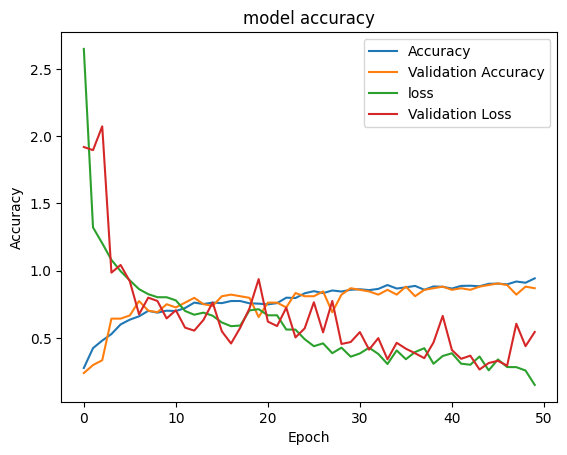

3/3 [==============================] - 0s 33ms/step - loss: 0.5436 - accuracy: 0.8690
Test: accuracy = 0.869048  ;  loss = 0.543577 


In [12]:
# Plotting the trained model
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

loss, accuracy = model.evaluate(val_ds)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

### Confusion Matrix

1/1 [==============================] - 0s 45ms/step
Result: 119/150
Time elapsed: 17.29890465736389
Accuracy based on testing dataset: 0.7933333333333333


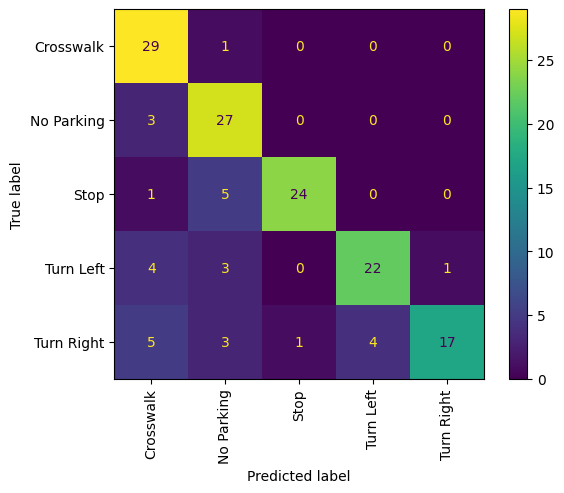

In [13]:
# Make predictions
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
import time

predictions_table = []
actuals_table = []
correct = 0
items = 0

start_time = time.time()
for index, name in enumerate(class_names):
    for file in os.listdir(f"Test/{ name }"):
        img = tf.keras.utils.load_img(f"Test/{ name }/{ file }", target_size=(image_size, image_size))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        
        actuals_table.append(index)
        predictions_table.append( np.argmax(predictions) )
        if index == np.argmax(predictions):
            correct += 1
        items += 1
end_time = time.time()

print(f"Result: { correct }/{ items }")
print(f"Time elapsed: { end_time - start_time }")
print(f"Accuracy based on testing dataset: { accuracy_score(actuals_table, predictions_table) }")
confusion_matrix = metrics.confusion_matrix(actuals_table, predictions_table)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
cm_display.plot(xticks_rotation='vertical')
plt.show() 

### Model Metrics

In [14]:
from sklearn.metrics import f1_score

f1 = f1_score(predictions_table, actuals_table, average='weighted')

print(f"Average f1 score: { f1 }")

Average f1 score: 0.7956788380701424


### Save the model

In [15]:
model.save('web/savedModel')__

INFO:tensorflow:Assets written to: web/savedModel\assets


INFO:tensorflow:Assets written to: web/savedModel\assets
